# Predict  an Annual Salary 2023 based on `Country`, `DevType`, `EdLevel` and `YearsCodePro`


## 2023 Developer Survey conducted by Stack Overflow

In May 2023 over 90,000 developers responded to the annual survey about how they learn and level up, which tools they're using, and which ones they want. Here we explore developer profile and programming, scripting, and markup languages developers used in 2023. The goal is to figure out high-paying professionals and their programming preferences.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

from matplotlib import pyplot as plt

import sys
sys.path.append("../src")

from config import url2023, url2024, file_name
from data.load_data import get_data
from data.clean_data import dataset_cleaned

# load row data
df = get_data(url2023, file_name)

# cleaned subset of the data
cdf = dataset_cleaned(df)

In [3]:
# load row data for 2024
df2024 = get_data(url2024, file_name)

# cleaned subset of the data for 2024
cdf2024 = dataset_cleaned(df2024)

## Remove outliers

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()
rscaler = RobustScaler()

outlier_threshold = 3

# calculate Z-score for annual salary
Zscore = pd.Series(scaler.fit_transform(cdf[["ConvertedCompYearly"]]).reshape(-1), index=cdf.index )

# calculate Z-score for annual salary using robust percentile measures
Zrscore = pd.Series(rscaler.fit_transform(cdf[["ConvertedCompYearly"]]).reshape(-1), index=cdf.index )

# define outliers based on Zscore
#fltr_outliers = Zscore.apply(lambda x: (x > outlier_threshold) or (x < -outlier_threshold))

# define outliers based on Zscore robust
fltr_outliers = Zrscore.apply(lambda x: (x > outlier_threshold) or (x < -outlier_threshold))

# remove outliers from dataset
cdf = cdf.loc[~fltr_outliers]

In [5]:
# delete outliers from data for 2024
Zrscore2024 = pd.Series(rscaler.fit_transform(cdf2024[["ConvertedCompYearly"]]).reshape(-1), index=cdf2024.index )
fltr_outliers2024 = Zrscore2024.apply(lambda x: (x > outlier_threshold) or (x < -outlier_threshold))
cdf2024 = cdf2024.loc[~fltr_outliers2024]

In [22]:
# columns to consider
#columns = ['EdLevel', 'DevType', 'Country', 'YearsCodePro', 'ConvertedCompYearly']
columns = ['DevType', 'Country', 'YearsCodePro', 'ConvertedCompYearly']
#columns = ['EdLevel', 'DevType', 'YearsCodePro', 'ConvertedCompYearly']

cdf = cdf.loc[:, columns]
cdf2024 = cdf2024.loc[:, columns]

In [23]:
cdf.DevType.unique()

array(['Senior Executive (C-Suite, VP, etc.)', 'Developer, back-end',
       'Developer, front-end', 'Developer, full-stack',
       'System administrator', 'Developer, QA or test', 'Designer',
       'Data scientist or machine learning specialist',
       'Data or business analyst', 'Security professional',
       'Research & Development role', 'Developer, mobile',
       'Database administrator',
       'Developer, embedded applications or devices',
       'Developer, desktop or enterprise applications', 'Engineer, data',
       'Product manager', 'Academic researcher',
       'Cloud infrastructure engineer', 'Other (please specify):',
       'Developer Experience', 'Engineering manager', 'DevOps specialist',
       'Engineer, site reliability', 'Project manager', 'Blockchain',
       'Developer, game or graphics', 'Developer Advocate',
       'Hardware Engineer', 'Educator', 'Scientist',
       'Marketing or sales professional', 'Student'], dtype=object)

In [24]:
# positions = ['Developer, full-stack']

# fltr_positions = cdf.DevType.apply(lambda x: x in positions)
# fltr_positions2024 = cdf2024.DevType.apply(lambda x: x in positions)

# cdf = cdf.loc[fltr_positions]
# cdf2024 = cdf2024.loc[fltr_positions2024]

In [25]:
# cdf = cdf.groupby(['EdLevel', 'DevType', 'YearsCodePro'])['ConvertedCompYearly'].mean().reset_index(level=['EdLevel', 'YearsCodePro'])
# cdf2024 = cdf2024.groupby(['EdLevel', 'DevType', 'YearsCodePro'])['ConvertedCompYearly'].mean().reset_index(level=['EdLevel', 'YearsCodePro'])

In [26]:
# datasets with NAs
print(f"Train: {cdf.shape}")
print(f"Test: {cdf2024.shape}")

Train: (45807, 4)
Test: (22418, 4)


In [27]:
# remove NAs
cdf.dropna(inplace=True, ignore_index=True)
cdf2024.dropna(inplace=True, ignore_index=True)

In [28]:
# datasets without NAs
print(f"Train: {cdf.shape}")
print(f"Test: {cdf2024.shape}")

Train: (45807, 4)
Test: (22418, 4)


In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures, TargetEncoder, OneHotEncoder, OrdinalEncoder, PolynomialFeatures

from sklearn.metrics import mean_squared_error, r2_score

In [30]:
# Prepare the features and target
# training and testing datasets

X_train = cdf.drop('ConvertedCompYearly', axis=1)
y_train = cdf['ConvertedCompYearly']

X_test = cdf2024.drop('ConvertedCompYearly', axis=1)
y_test = cdf2024['ConvertedCompYearly']

In [31]:
# Identify categorical and numerical columns

categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

# Create the preprocessor with the transformations

preprocessor = ColumnTransformer(
    transformers=[
        ('num', PolynomialFeatures(degree=2), numerical_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, min_frequency=100), categorical_cols)
       # ('cat', OneHotEncoder(drop="first", handle_unknown='ignore'), categorical_cols) #handle_unknown='infrequent_if_exist'
       # ('cat', TargetEncoder(target_type='continuous', cv=3), categorical_cols)
    ]
)

# preprocessor = ColumnTransformer(
#     transformers=[
        
#         ('ed', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ["EdLevel"]),
#         ('dev', OneHotEncoder(drop="first", handle_unknown='ignore'), ["DevType"]), # handle_unknown='infrequent_if_exist'
#         ('country', TargetEncoder(target_type='continuous', cv=5), ["Country"])
#     ]
# )

In [51]:
numerical_cols

Index(['YearsCodePro'], dtype='object')

In [32]:
# Create a pipeline with preprocessing
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the preprocessor on the training data
X_train_processed = pipeline.fit_transform(X_train, y_train)
X_test_processed = pipeline.transform(X_test)

In [33]:
pipeline.get_feature_names_out()

array(['num__1', 'num__YearsCodePro', 'num__YearsCodePro^2',
       'cat__DevType', 'cat__Country'], dtype=object)

In [47]:
#model =  LinearRegression()
#model = DecisionTreeRegressor(max_depth=30)

model = HistGradientBoostingRegressor(max_depth=20)

model.fit(X_train_processed, y_train)

R2_train = model.score(X_train_processed, y_train)

In [48]:
# predict salary with the trained model on the test data set

y_pred = model.predict(X_test_processed)

# RSS = ((y_test-y_pred)**2).sum()
# TSS = ((y_train.mean()-y_test)**2).sum()
# R2_test = 1.0 - RSS/TSS

R2_test = r2_score(y_test, y_pred)


Regression Model

Model performance on train data R^2 = 0.5917
Model performance on test data R^2 = 0.5803
Baseline model prediction 86689


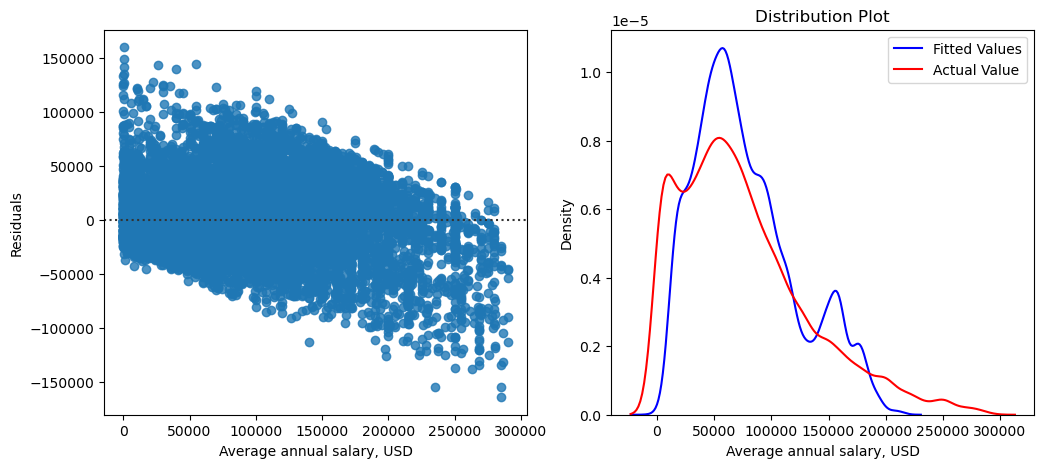

In [49]:
# Evaluate model performance on test data

print('\nRegression Model\n')

print("Model performance on train data R^2 = {}".format(round(R2_train,4)))
print("Model performance on test data R^2 = {}".format(round(R2_test,4)))
    
print("Baseline model prediction {}".format(round(y_train.mean() )) )
# print("RSS = {}".format(RSS))
# print("TSS = {}".format(TSS))

width=12
height=5

fig = plt.figure(figsize=(width, height))
ax1 = fig.add_subplot(121)
sns.residplot(x=y_test, y=y_pred)
plt.xlabel("Average annual salary, USD")
plt.ylabel("Residuals")

ax2 = fig.add_subplot(122)
sns.kdeplot(y_pred, color="b", label="Fitted Values")
sns.kdeplot(y_test, color="r", label="Actual Value")
ax2.legend()
plt.title("Distribution Plot")
plt.xlabel("Average annual salary, USD")

plt.show()
plt.close()

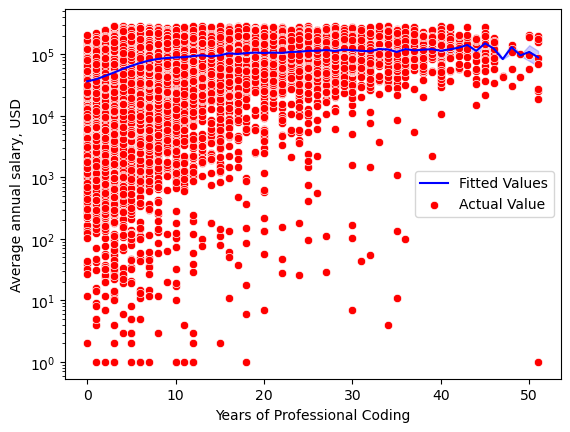

In [50]:
sns.lineplot(x=cdf2024["YearsCodePro"], y=y_pred, color="b", label="Fitted Values")
sns.scatterplot(x=cdf2024["YearsCodePro"], y=y_test, color="r", label="Actual Value")
plt.legend()
plt.xlabel("Years of Professional Coding")
plt.ylabel("Average annual salary, USD")
plt.yscale('log')

plt.show()
plt.close()